<h1 style="text-align:center">Remind me again how we did that?  Creating convenient and reproducible workflows using Jupyter Notebook</h1>

<p style="font-size:24px; text-align:center">
MORPC Data Day<br />
March 1, 2023<br />
</p>

<p style="text-align:center">
    <a href="mailto:aporr@morpc.org">Adam Porr</a><br />
    Research & Data Officer<br />
    <a href="https://morpc.org">Mid-Ohio Regional Planning Commission</a>
</p>

## Abstract

Attendees will be introduced to Jupyter notebooks and how they can be used to produce well-documented automated workflows using Python code.  We will walk through an existing Jupyter notebook that makes use of the popular Pandas data analysis and manipulation library (among others) and its geographic extensions (i.e. GeoPandas) to retrieve geographic data and attribute data from the Census website, integrate the retrieved data, and perform a simple common analysis task using the data.  We anticipate that attendees will already have experience downloading, integrating, and analyzing Census data using other tools (e.g., data.census.gov, Excel, ArcGIS), therefore this presentation will focus on the automation of this workflow using Jupyter and the efficiency, transparency, and reproducibility benefits that can be realized from this strategy.  All of tools demonstrated during the presentation will be free and open source, and the notebook will be made available so that attendees can experiment with the workflow after the presentation.  Basic familiarity with Python or other programming languages is beneficial to understand the workflow implementation, but not necessary to appreciate the primary learning objectives.

## Introduction

My goal for this presentation: I want you to **want** to create reproducible workflows.  

![Dishes scene from "The Break Up"](https://images.squarespace-cdn.com/content/v1/5aa40c3589c172a816875fd2/1579382959877-CX922N5S0DF9LMLUR75V/Dishes.jpg?format=1000w)

### How I'll make my case

  - Rant about the problem as I see it.
  - Introduce a shiny new tool (Jupyter)
  - Show off a tiny fraction of the cool things you can do with Jupyter while...
    - Demonstrating how work done in Jupyter is inherently more reproducible
    - Suggesting practices to make your Jupyter workflows even more reproducible

## Why we need reproducible workflows

### Have you every been guilty of this?

![XKCD comic](https://imgs.xkcd.com/comics/documents.png)

Image credit: Randall Monroe ([XKCD](https://xkcd.com/1459/))

My favorite is "Big official report FINAL v2 AMP comments.docx"

### Or this?

![File not found](./images/file_not_found.png)

### Or this?

```#TODO: Figure out what I’m doing here and comment accordingly.```

```// Peter wrote this, nobody knows what it does, don't change it!```

```// drunk, fix later```

 ### Why are we so bad a creating reproducible workflows?
 
 ![Comic](https://image.slidesharecdn.com/gooddocumentationpractice-124654020836-phpapp01/95/good-documentation-practice-15-728.jpg?cb=1264761241)
 

  - Creating reproducible workflows used to be difficult and tedious
  - No wonder data scientists (and most other people) are bad at making workflows reproducible
  - Creating reproducible workflows will lead to better:
      - Transparency
      - Efficiency
      - Sanity!

## The case for programming your analysis

### Code inherently provides documentation

```r = requests.get(DECENNIAL_API_SOURCE_URL, params=DECENNIAL_API_PARAMS)
decennialRaw = r.json()
columns = decennialRaw.pop(0)
decennialData = pd.DataFrame.from_records(decennialRaw, columns=columns) \
    .filter(items=morpc.avro_get_field_names(decennialSchema), axis="columns") \
    .astype(morpc.avro_to_pandas_dtype_map(decennialSchema)) \
    .rename(columns=morpc.avro_map_to_first_alias(decennialSchema)) 
decennialData["GEOID"] = decennialData["GEOID"].apply(lambda x:x.split("US")[1])
```

![Example JSON](./images/json.png)

![Example table](./images/table.png)

### Code does only what you tell it to do

![Comic](https://media.tumblr.com/tumblr_lxncwaZ4f21qhg0wt.jpg)

### Code allows you to repeat steps with minimal effort

![Example model](./images/model.svg)

## The case for literate programming

### A few thoughtful, well-placed comments go a long way

```
<svg width="200" height="250" version="1.1" xmlns="http://www.w3.org/2000/svg">
  <polygon points="50 160 55 180 70 180 60 190 65 205 50 195 35 205 40 190 30 180 45 180"
      stroke="green" fill="transparent" stroke-width="5"/>
</svg>
```

Draw a green five-pointed star

### But a picture is even better!

![Star](./images/star.png)

### Sometimes you just need the gist

![Outline](./images/jupyter_outline.png)

### Literate programming reads like a book but runs like code

![Donald Knuth, the author of Literate Programming](./images/donald_knuth.png)

### Jupyter makes literate programming possible for mere mortals

![Jupyter notebook screenshot](https://jupyterlab.readthedocs.io/en/stable/_images/jupyterlab.png)

## Literate programming by example

### Write an introduction

In the remainder of this notebook, I'll demonstrate a simple (but hopefully compelling) use case for Jupyter that highlights it's literate programming capabilities.  It will use the popular pandas data analysis library and its spatially-enabled companion, geopandas.  The notebook will fetch U.S. Census data from the web, do some common manipulations to it, plot it, map it, and perform a statistical analysis.  Since I included an introduction, you can decide whether you care about any of that without having to try to interpret the rest of the document.

### Specify the input and output data

It's good to specify all prerequisites at the beginning of the document, including data, parameters, and required libraries.  This helps the reader understand the inputs and outputs and what steps they may have to take prior to running the script.

#### Input data

We'll retrieve population estimates and factors of population change from the Census Population Estimates Program (PEP) website and archive a local copy.

In [1]:
CENSUS_PEP_URL = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv"
CENSUS_PEP_ARCHIVE_PATH = "./input_data/census_pep.csv"

We'll also need the county polygons Shapefile from the Census geography program.

In [2]:
CENSUS_COUNTY_POLYGONS_URL = "https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip"
CENSUS_COUNTY_POLYGONS_ARCHIVE_PATH = "./input_data/county_polygons.shp"

#### Output data

We'll produce a spatial database (Shapefile) that includes the geometries and numerical population change for Franklin County and the surrounding counties.

In [3]:
POPCHANGE_FEATURECLASS_PATH = "./output_data/popchange.shp"

### Don't forget to specify the schemas!

Schemas help humans to understand how datasets are structured and what the variables represent.  If the schema is specified in a machine readable format like this, then the computer can parse the data without additional effort from a human.

In [4]:
POPCHG_FEATURECLASS_SCHEMA = {
    "type": "record",
    "doc": "Numerical population change for Central Ohio counties for the years 2010 to 2019.",
    "fields": [
        {"name":"CTYNAME", "type":"string", "doc":"Name of the county"},
        {"name":"2010", "type":"int", "doc":"Numeric change in resident total population 4/1/2010 to 7/1/2010"},
        {"name":"2011", "type":"int", "doc":"Numeric change in resident total population 7/1/2010 to 7/1/2011"},
        {"name":"2012", "type":"int", "doc":"Numeric change in resident total population 7/1/2011 to 7/1/2012"},
        {"name":"2013", "type":"int", "doc":"Numeric change in resident total population 7/1/2012 to 7/1/2013"},
        {"name":"2014", "type":"int", "doc":"Numeric change in resident total population 7/1/2013 to 7/1/2014"},
        {"name":"2015", "type":"int", "doc":"Numeric change in resident total population 7/1/2014 to 7/1/2015"},
        {"name":"2016", "type":"int", "doc":"Numeric change in resident total population 7/1/2015 to 7/1/2016"},
        {"name":"2017", "type":"int", "doc":"Numeric change in resident total population 7/1/2016 to 7/1/2017"},
        {"name":"2018", "type":"int", "doc":"Numeric change in resident total population 7/1/2017 to 7/1/2018"},
        {"name":"2019", "type":"int", "doc":"Numeric change in resident total population 7/1/2018 to 7/1/2019"}
    ]
}

### Specify any parameters

In [5]:
# For COUNTY_NAMES, enter a list of strings representing the names of the counties of interest
COUNTY_NAMES = \
    ["Franklin","Fairfield","Pickaway","Madison", 
     "Union", "Delaware", "Licking"]

# For STATE_NAME, enter a string representing name of the state where the counties of interest
# are located.  For STATE_FIPS, enter the two digit FIPS code assigned to the state by the Census Bureau.
STATE_NAME = "Ohio"
STATE_FIPS = "39"

### Import required libraries

In [6]:
import os                  # Perform basic filesystem operations, such as creating directories
import pandas as pd        # Create and manipulate tabular data in the form of dataframes
import geopandas as gpd    # Create and manipulate spatial data in the form of geodataframes
from scipy import stats    # Perform statistical analysis
import numpy as np         # General purpose numerical computation library

### Prepare the environment

Create subdirectories to store the input data and output data if they don't already exist.

In [7]:
if not os.path.exists("./input_data"):
    os.makedirs("./input_data")
    
if not os.path.exists("./output_data"):
    os.makedirs("./output_data")    

### Finally, let's get some data! Pandas makes working tabular data a dream.
Read the CSV file directly from the Census website. This particular file uses an atypical text encoding format, so we have to specify it explicitly.  Pandas can determine the encoding for most CSV files automatically. After downloading the file, save an archival copy and display some sample records.

In [8]:
censusPepRaw = pd.read_csv(CENSUS_PEP_URL, encoding="ISO-8859-1")
censusPepRaw.to_csv(CENSUS_PEP_ARCHIVE_PATH, index=False)
# If you need to load the archival copy, use the following line instead
#censusPepRaw = pd.read_csv(CENSUS_PEP_ARCHIVE_PATH, encoding="ISO-8859-1")
censusPepRaw.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,40,3,6,1,0,Alabama,Alabama,4779736,4780125,4785437,...,1.917501,0.578434,1.186314,1.522549,0.563489,0.626357,0.745172,1.090366,1.773786,2.483744
1,50,3,6,1,1,Alabama,Autauga County,54571,54597,54773,...,4.847310,6.018182,-6.226119,-3.902226,1.970443,-1.712875,4.777171,0.849656,0.540916,4.560062
2,50,3,6,1,3,Alabama,Baldwin County,182265,182265,183112,...,24.017829,16.641870,17.488579,22.751474,20.184334,17.725964,21.279291,22.398256,24.727215,24.380567
3,50,3,6,1,5,Alabama,Barbour County,27457,27455,27327,...,-5.690302,0.292676,-6.897817,-8.132185,-5.140431,-15.724575,-18.238016,-24.998528,-8.754922,-5.165664
4,50,3,6,1,7,Alabama,Bibb County,22915,22915,22870,...,1.385134,-4.998356,-3.787545,-5.797999,1.331144,1.329817,-0.708717,-3.234669,-6.857092,1.831952


Extract only the records that are county level (SUMLEV equal to 50) and whose state name (STNAME) and county name (CTYNAME) match those specified in the parameters.  When specifying the county names, it is necessary to append " County" to match the format of CTYNAME.

In [9]:
censusPep = censusPepRaw.loc[ \
    (censusPepRaw["SUMLEV"] == 50) & \
    (censusPepRaw["STNAME"] == STATE_NAME) & \
    (censusPepRaw["CTYNAME"].isin(["{} County".format(x) for x in COUNTY_NAMES]))
].copy()
censusPep.head()     

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
2099,50,2,3,39,41,Ohio,Delaware County,174214,174172,175099,...,14.546139,12.775921,7.779526,16.534473,14.817779,14.727125,13.806701,13.677911,16.139481,15.569631
2101,50,2,3,39,45,Ohio,Fairfield County,146156,146194,146417,...,7.398997,1.812045,-2.723491,6.477607,7.561272,3.269079,7.242397,10.153671,5.916284,8.151654
2103,50,2,3,39,49,Ohio,Franklin County,1163414,1163476,1166202,...,-2.261042,4.535147,7.345857,8.393981,7.728997,7.809282,5.912705,9.237498,2.811147,0.478576
2123,50,2,3,39,89,Ohio,Licking County,166492,166482,166705,...,5.026551,-0.197682,0.035847,2.701979,3.131373,5.258499,5.901858,7.372472,9.940364,5.349930
2127,50,2,3,39,97,Ohio,Madison County,43435,43438,43434,...,6.350987,-8.665712,-4.180942,6.887196,15.062589,3.222914,-17.116870,15.374408,7.463530,6.620287


The CSV includes **a lot** of variables, but we are only interested in numerical population change.

In [10]:
print(", ".join(list(censusPep.columns)))

SUMLEV, REGION, DIVISION, STATE, COUNTY, STNAME, CTYNAME, CENSUS2010POP, ESTIMATESBASE2010, POPESTIMATE2010, POPESTIMATE2011, POPESTIMATE2012, POPESTIMATE2013, POPESTIMATE2014, POPESTIMATE2015, POPESTIMATE2016, POPESTIMATE2017, POPESTIMATE2018, POPESTIMATE2019, NPOPCHG_2010, NPOPCHG_2011, NPOPCHG_2012, NPOPCHG_2013, NPOPCHG_2014, NPOPCHG_2015, NPOPCHG_2016, NPOPCHG_2017, NPOPCHG_2018, NPOPCHG_2019, BIRTHS2010, BIRTHS2011, BIRTHS2012, BIRTHS2013, BIRTHS2014, BIRTHS2015, BIRTHS2016, BIRTHS2017, BIRTHS2018, BIRTHS2019, DEATHS2010, DEATHS2011, DEATHS2012, DEATHS2013, DEATHS2014, DEATHS2015, DEATHS2016, DEATHS2017, DEATHS2018, DEATHS2019, NATURALINC2010, NATURALINC2011, NATURALINC2012, NATURALINC2013, NATURALINC2014, NATURALINC2015, NATURALINC2016, NATURALINC2017, NATURALINC2018, NATURALINC2019, INTERNATIONALMIG2010, INTERNATIONALMIG2011, INTERNATIONALMIG2012, INTERNATIONALMIG2013, INTERNATIONALMIG2014, INTERNATIONALMIG2015, INTERNATIONALMIG2016, INTERNATIONALMIG2017, INTERNATIONALMIG2018, 

Create a new dataframe that includes only the county name (CTYNAME) and fields whose name includes "NPOPCHG"

In [11]:
censusPepPopChg = pd.concat([
    censusPep.filter(like="CTYNAME", axis="columns"), 
    censusPep.filter(like="NPOPCHG", axis="columns")
], axis="columns")
censusPepPopChg.head()

,CTYNAME,NPOPCHG_2010,NPOPCHG_2011,NPOPCHG_2012,NPOPCHG_2013,NPOPCHG_2014,NPOPCHG_2015,NPOPCHG_2016,NPOPCHG_2017,NPOPCHG_2018,NPOPCHG_2019
2099,Delaware County,927,3436,2592,4253,4060,3951,3753,3726,4221,4086
2101,Fairfield County,223,757,127,1495,1564,894,1535,1897,1296,1592
2103,Franklin County,2726,14598,18245,19833,19484,19024,17064,21060,12188,9058
2123,Licking County,223,459,425,872,949,1201,1382,1624,2049,1196
2127,Madison County,-4,-320,-123,265,724,159,-762,664,348,342


Eliminate the " County" suffix from the county names.

In [12]:
censusPepPopChg["CTYNAME"] = censusPepPopChg["CTYNAME"].str.replace(" County", "")

Aside from CTYNAME, all of our columns include two parts separated by an underscore - a prefix "NPOPCHG" and a suffix representing the four-digit year.  Rename the columns, retaining only the year.  Index by county name.

In [13]:
censusPepPopChg = censusPepPopChg \
    .set_index("CTYNAME") \
    .rename(columns=(lambda x:x[-4:]))
censusPepPopChg.head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
CTYNAME,,,,,,,,,,
Delaware,927,3436,2592,4253,4060,3951,3753,3726,4221,4086
Fairfield,223,757,127,1495,1564,894,1535,1897,1296,1592
Franklin,2726,14598,18245,19833,19484,19024,17064,21060,12188,9058
Licking,223,459,425,872,949,1201,1382,1624,2049,1196
Madison,-4,-320,-123,265,724,159,-762,664,348,342


### Jupyter can create charts.

Plot the 2019 population change by county as a horizontal bar chart and Franklin County's population change by year as a line chart.

<AxesSubplot:title={'center':'Franklin County population change by year'}>

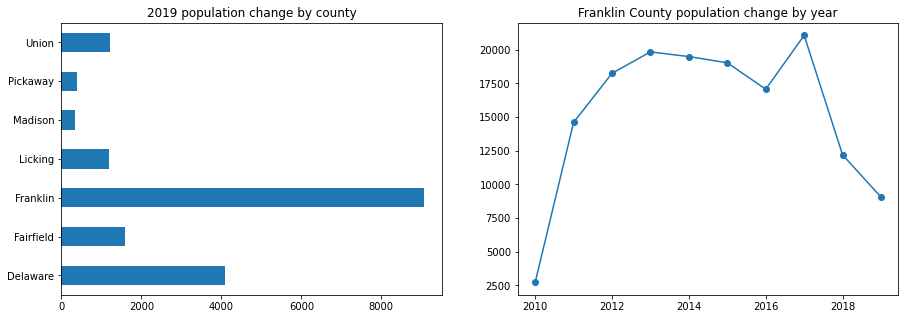

In [14]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
censusPepPopChg["2019"].plot.barh(ax=axes[0], title="2019 population change by county", xlabel="")
censusPepPopChg.loc["Franklin"].plot(ax=axes[1], title="Franklin County population change by year", style="o-")

### Maps too!

Read the county geography Shapefile directly from the Census website.  Note that GeoPandas can read the zipped Shapefile directly; it is not necessary to download it and unzip it first. Save an archival copy of the Shapefile.

In [15]:
censusCountyPolysRaw = gpd.read_file(CENSUS_COUNTY_POLYGONS_URL)
censusCountyPolysRaw.to_file(CENSUS_COUNTY_POLYGONS_ARCHIVE_PATH, driver="ESRI Shapefile")
# If you need to load the archival copy, use the following line instead
# censusCountyPolysRaw = gpd.read_file(CENSUS_COUNTY_POLYGONS_ARCHIVE_PATH)
censusCountyPolysRaw.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477652222,10690952,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680962890,61582307,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016819475,29089486,+34.3592729,-104.3686961,"POLYGON ((-104.56739 33.99757, -104.56772 33.9..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169270569,22849484,+40.7835474,-096.6886584,"POLYGON ((-96.91075 40.78494, -96.91075 40.790..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645188,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."


This Shapefile includes all counties nationwide.  Filter by state using the state FIPS code (state name is not available). Then, as before, filter by county name after appending the " County" suffix. After filtering eliminate the suffix. Index by county name.

In [16]:
censusCountyPolys = censusCountyPolysRaw.loc[ \
    (censusCountyPolysRaw["STATEFP"] == STATE_FIPS) & \
    (censusCountyPolysRaw["NAMELSAD"].isin(["{} County".format(x) for x in COUNTY_NAMES]))
].copy()
censusCountyPolys["NAMELSAD"] = censusCountyPolys["NAMELSAD"].str.replace(" County", "")
censusCountyPolys = censusCountyPolys.set_index(["NAMELSAD"])
censusCountyPolys.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
NAMELSAD,,,,,,,,,,,,,,,,,
Pickaway,39,129,01074077,39129,Pickaway,06,H1,G4020,198,18140,None,A,1298175198,13790233,+39.6489470,-083.0528267,"POLYGON ((-83.01307 39.80439, -83.01285 39.804..."
Delaware,39,041,01074033,39041,Delaware,06,H1,G4020,198,18140,None,A,1147778026,36698376,+40.2789411,-083.0074622,"POLYGON ((-83.19229 40.24440, -83.19672 40.244..."
Madison,39,097,01074061,39097,Madison,06,H1,G4020,198,18140,None,A,1206445849,2119319,+39.8966074,-083.4008847,"POLYGON ((-83.54053 39.91715, -83.54039 39.917..."
Franklin,39,049,01074037,39049,Franklin,06,H1,G4020,198,18140,None,A,1378938272,29041546,+39.9698749,-083.0090858,"POLYGON ((-83.01188 40.13656, -83.01171 40.136..."
Union,39,159,01074091,39159,Union,06,H1,G4020,198,18140,None,A,1118161949,13254689,+40.2959008,-083.3670416,"POLYGON ((-83.52822 40.43664, -83.52776 40.440..."


Join our population change data to the polygons, aligning on the index (i.e. the county name).

In [17]:
censusPepPolys = gpd.GeoDataFrame(data=censusPepPopChg.copy(), geometry=censusCountyPolys["geometry"])
censusPepPolys.head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,geometry
CTYNAME,,,,,,,,,,,
Delaware,927,3436,2592,4253,4060,3951,3753,3726,4221,4086,"POLYGON ((-83.19229 40.24440, -83.19672 40.244..."
Fairfield,223,757,127,1495,1564,894,1535,1897,1296,1592,"POLYGON ((-82.80248 39.82295, -82.80242 39.823..."
Franklin,2726,14598,18245,19833,19484,19024,17064,21060,12188,9058,"POLYGON ((-83.01188 40.13656, -83.01171 40.136..."
Licking,223,459,425,872,949,1201,1382,1624,2049,1196,"POLYGON ((-82.76183 40.12586, -82.76181 40.125..."
Madison,-4,-320,-123,265,724,159,-762,664,348,342,"POLYGON ((-83.54053 39.91715, -83.54039 39.917..."


Make a nice interactive map. Yes, this is all it takes!

In [18]:
censusPepPolys.explore(column="2019")

### And statistical analyses? You bet.

Support for statistical analysis in pandas is limited, so we'll use the statsmodels library instead.  Convert our time index (column names) and time series values (Franklin County population change) to individual variables for convenience.  Note that the column names are strings, so it is necessary to convert them to integers.

In [19]:
x = censusPepPopChg.columns.to_series().astype("int")
y = censusPepPopChg.loc["Franklin"]

Perform linear regression and calculate slope and standard error

In [20]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
trendline = slope * x + intercept
print("Slope: {:1.2f}".format(slope))
print("Intercept: {:1.2f}".format(intercept))
print("Standard error: {:1.2f}".format(std_err))
print("Standard error as percent of mean: {:1.2f}%".format(std_err/y.mean()*100))

Slope: 275.31
Intercept: -539282.16
Standard error: 671.80
Standard error as percent of mean: 4.38%


Calculate t-statistic and p-value for one-tailed test (significance level = 0.05) and print results

In [21]:
def print_trend_assessments(p_value, alpha, slope):
    if p_value < alpha and slope < 0:
        print("There is significant evidence (p = {:.4f}) of a negative trend".format(p_value))
    else:
        print("There is no significant evidence of a negative trend")
    if p_value < alpha and slope > 0:
        print("There is significant evidence (p = {:.4f}) of a positive trend".format(p_value))
    else:
        print("There is no significant evidence of a positive trend")

There is no significant evidence of a negative trend
There is no significant evidence of a positive trend


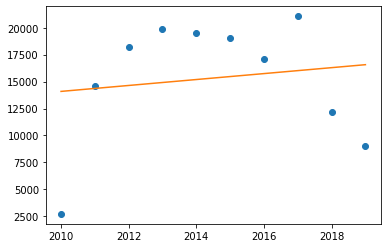

In [22]:
t_stat = slope / (std_err / np.sqrt(len(x)))
p_value = stats.t.sf(np.abs(t_stat), len(x)-2)

alpha = 0.05
print_trend_assessments(p_value, alpha, slope)

plt.plot(x,y,"o")
plt.plot(x,trendline)
plt.show()

### Need some nicely-formatted output for the boss? Jupyter has you covered.

<table>
    <tr>
        <td width="30%" style="vertical-align:top">
            <ul>
                <li>HTML</li>
                <li>PDF</li>
                <li>Microsoft Word</li>
                <li>Presentations</li>
                <li>Interactive dashboards</li>
                <li>Websites</li>
                <li>Books</li>
            </ul>
        </td>
        <td>
            <img src="https://quarto.org/docs/gallery/interactive/interactive-ojs.png" alt="Dashboard example screenshot" />
        </td>
    </tr>
</table>

Note: Some of these export options are built into Jupyter Notebook and JupyterLab.  For others, you need a more sophisticated export tool like [Quarto](https://quarto.org/).

## Closing thoughts

### Your environment should be reproducible too

  - Python virtual environments (for Python-only work)
  - Docker (for more complex workflows)
  - Documentation (if you like doing extra work)
  
![venv](./images/venv.png)

### Use version control

  - Lots of choices. Git (often via GitHub) is most popular.
  - Control versions of your data too!
  - Text formats allow you to see diffs
  
![GitHub Desktop](./images/github.png)

### You can do all of this in R too

![RMarkdown](https://d33wubrfki0l68.cloudfront.net/26639e1fec7fa314b8fe521d1e8f97de10ff12a8/66448/images/bandtwo2.png)

### No Jupyter? No problem. Binder lets you run Jupyter in the cloud.

![Binder](./images/binder.png)

### Jupyter is Free Software (so are Python and R)

```
MIT License

Copyright (c) [year] [fullname]

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```

### 10 commandments of reproducible data science

  1. Thou shalt **provide a succint and simple introduction**
  1. Thou shalt **capture every step and assumption**
  1. Thou shalt **capture metadata** for inputs and outputs
  1. Thou shalt **explain complex operations** in words thine peers can understand
  1. Thou shalt **collect prerequisite steps in one place** 
  1. Thou shalt **preserve versions** of thine process
  1. Thou shalt **get thine input data directly from the source**
  1. Thou shalt **save a copy of thine input data**
  1. Thou shalt **document thine analysis environment**
  1. Thou shalt use **freely-available tools** that thine peers have access to
  
<p style="font-size:2em; font-weight:bold; text-align:center">Questions?</p>

## Accessing the content from this presentation

All of the content presented today is publicly available in GitHub:

https://github.com/aporr/jupyter-reproducible-workflows

The slides are available directly from the following URL:

https://aporr.github.io/jupyter-reproducible-workflows/slides.html

The slides are implemented using Reveal.js, which [arranges slides in a 2D layout](https://revealjs.com/vertical-slides/).  Press `PGDN` to move to the next slide or `PGUP` to move to previous slide, or press `ESC` to see an overview and move through the slides non-linearly.